## Introduction

Welcome back to the fourth blog post in the Python for Beginners series!

In this blog post, I’m going to walk you through how to simulate heat diffusion in two dimensions using different numerical methods. 

*Why?* 

Because it’s going to be fun, educational, and super satisfying, watching heat spread in a perfectly symmetric way. 

*We will be going over 4 methods to create heat diffusions in the 2D space.*

Let's start off with setting up our code.

In [7]:
# Import Necessary Libraries
import time
import inspect
import numpy as np
from jax import jit
import heat_equation
import jax.numpy as jnp
from jax.experimental import sparse
from matplotlib import pyplot as plt
from heat_equation import get_sparse_A
from heat_equation import advance_time_jax
from heat_equation import advance_time_numpy
from heat_equation import get_A, advance_time_matvecmul

In [2]:
# Define parameters
N = 101
epsilon = 0.2
iterations = 2700

To avoid repeating code across different heat simulation methods, we will create a function that handles the initialization of the heat source, runs the simulation, and generates visualizations. 

This function works with all methods throughout this blog, which makes it easy to swap between different approaches without duplicating logic.

In [3]:
def heat_simulation(N, epsilon, iterations, method, matrix, advance):
    # Define parameters
    iterations = iterations
    
    # Initialize heat source at center
    # Checks for what model
    if advance == advance_time_jax:
        u = jnp.zeros((N, N))
        u = u.at[N//2, N//2].set(1.0)
    else:
        u = np.zeros((N, N))
        u[N//2, N//2] = 1.0 
    
    # Get matrix A
    A = matrix(N)
    
    # Run a few warm-up iterations to compile (only need for JAX)
    if advance == advance_time_jax:
        for _ in range(5):
            u = advance_time_jax(u, epsilon)
    
    # Store for visualization
    graph = []
    
    # Track computation time
    start_time = time.time()
    
    # Run
    for i in range(iterations):
        # Checks for which model
        if advance == advance_time_matvecmul:
            u = advance(A, u, epsilon)
        else:
            u = advance(u, epsilon)
        
        # Save every 300 steps
        if (i+1) % 300 == 0:  
            graph.append(u.copy())
    
    # Track end time
    end_time = time.time()
    
    # Print computation time
    print(f"Total computation time ({method}): {end_time - start_time:.2f} seconds")
    
    # Plot results in 3x3 grid
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    
    for idx, ax in enumerate(axes.flat):
        if idx < len(graph):
            im = ax.imshow(graph[idx], cmap='viridis', origin='lower')
            ax.set_title(f"Iteration {(idx+1) * 300}")
    
    plt.tight_layout()
    plt.show()

*Let's start off with our first (and excruciatingly slow) method.*

## Method 1: The Matrix Multiplication Approach
In heat diffusion simulations, matrix multiplication is a powerful tool to model how heat spreads across a grid. We break the 2D grid into smaller points, with each point representing the temperature at that location. 

The finite difference matrix A, captures how each point is influenced by its neighbors and by multiplying this matrix with the current temperature values, we can quickly calculate the temperature at each point for the next time step. This process allows us to simulate heat diffusion efficiently, using matrix operations to update the entire grid in one go, making sure the simulation runs smoothly and accurately.

The **advance_time_matvecmul** function helps to do just that. It updates the state of by performing a matrix multiplication. By incorporating the finite difference matrix A, it models the heat diffusion process and advances the system one step forward in time, returning the updated temperature grid.

In [8]:
@jit
def advance_time_matvecmul(A, u, epsilon):
    """Advances the simulation by one timestep, using matrix-vector multiplication
    
    Args:
        A: The 2d finite difference matrix, N^2 x N^2. 
        u: N x N grid state at timestep k.
        epsilon: stability constant.

    Returns:
        N x N Grid state at timestep k+1.
    """
    
    N = u.shape[0]
    u = u + epsilon * (A @ u.flatten()).reshape((N, N))
    return u

To simulate heat diffusion in a 2D space using matrix-vector multiplication, we first need to define a function **get_A(N)** in the file **heat_equation.py** along with the function **advance_time_matvecmul**. This function takes an integer **N** as input and returns the corresponding matrix **A**. This matrix is crucial in representing the heat diffusion over time.

In [9]:
def get_A(N):
    """
    Constructs the 2D finite difference matrix A for the heat equation.
    
    Args:
        N (int): Grid size (NxN).
        
    Returns:
        A (numpy.ndarray): Finite difference matrix of size (N^2 x N^2).
    """
    # Total number of points in the grid
    n = N * N  
    diagonals = [
        -4 * np.ones(n),
        np.ones(n - 1),
        np.ones(n - 1),
        np.ones(n - N),
        np.ones(n - N)
    ]
    
    # Set zero at the right boundary to avoid wrap-around
    diagonals[1][(N-1)::N] = 0
    diagonals[2][(N-1)::N] = 0
    
    # Construct the matrix
    A = (
        np.diag(diagonals[0]) + 
        np.diag(diagonals[1], 1) + np.diag(diagonals[2], -1) +  
        np.diag(diagonals[3], N) + np.diag(diagonals[4], -N)
    )
    
    return A

Now that we have our matrix A defined, we can run the simulation by calling the **get_A(N)** function alongside the **advance_time_matvecmul()** method. This will simulate the heat diffusion process for 2700 iterations, with each iteration representing a time step in the diffusion process.

In [13]:
print(inspect.getsource(heat_simulation))

def heat_simulation(N, epsilon, iterations, method, matrix, advance):
    # Define parameters
    iterations = iterations
    
    # Initialize heat source at center
    # Checks for what model
    if advance == advance_time_jax:
        u = jnp.zeros((N, N))
        u = u.at[N//2, N//2].set(1.0)
    else:
        u = np.zeros((N, N))
        u[N//2, N//2] = 1.0 
    
    # Get matrix A
    A = matrix(N)
    
    # Run a few warm-up iterations to compile (only need for JAX)
    if advance == advance_time_jax:
        for _ in range(5):
            u = advance_time_jax(u, epsilon)
    
    # Store for visualization
    graph = []
    
    # Track computation time
    start_time = time.time()
    
    # Run
    for i in range(iterations):
        # Checks for which model
        if advance == advance_time_matvecmul:
            u = advance(A, u, epsilon)
        else:
            u = advance(u, epsilon)
        
        # Save every 300 steps
        if (i+1) % 300 == 0:  
            gr

Total computation time (matrix multiplication): 424.18 seconds


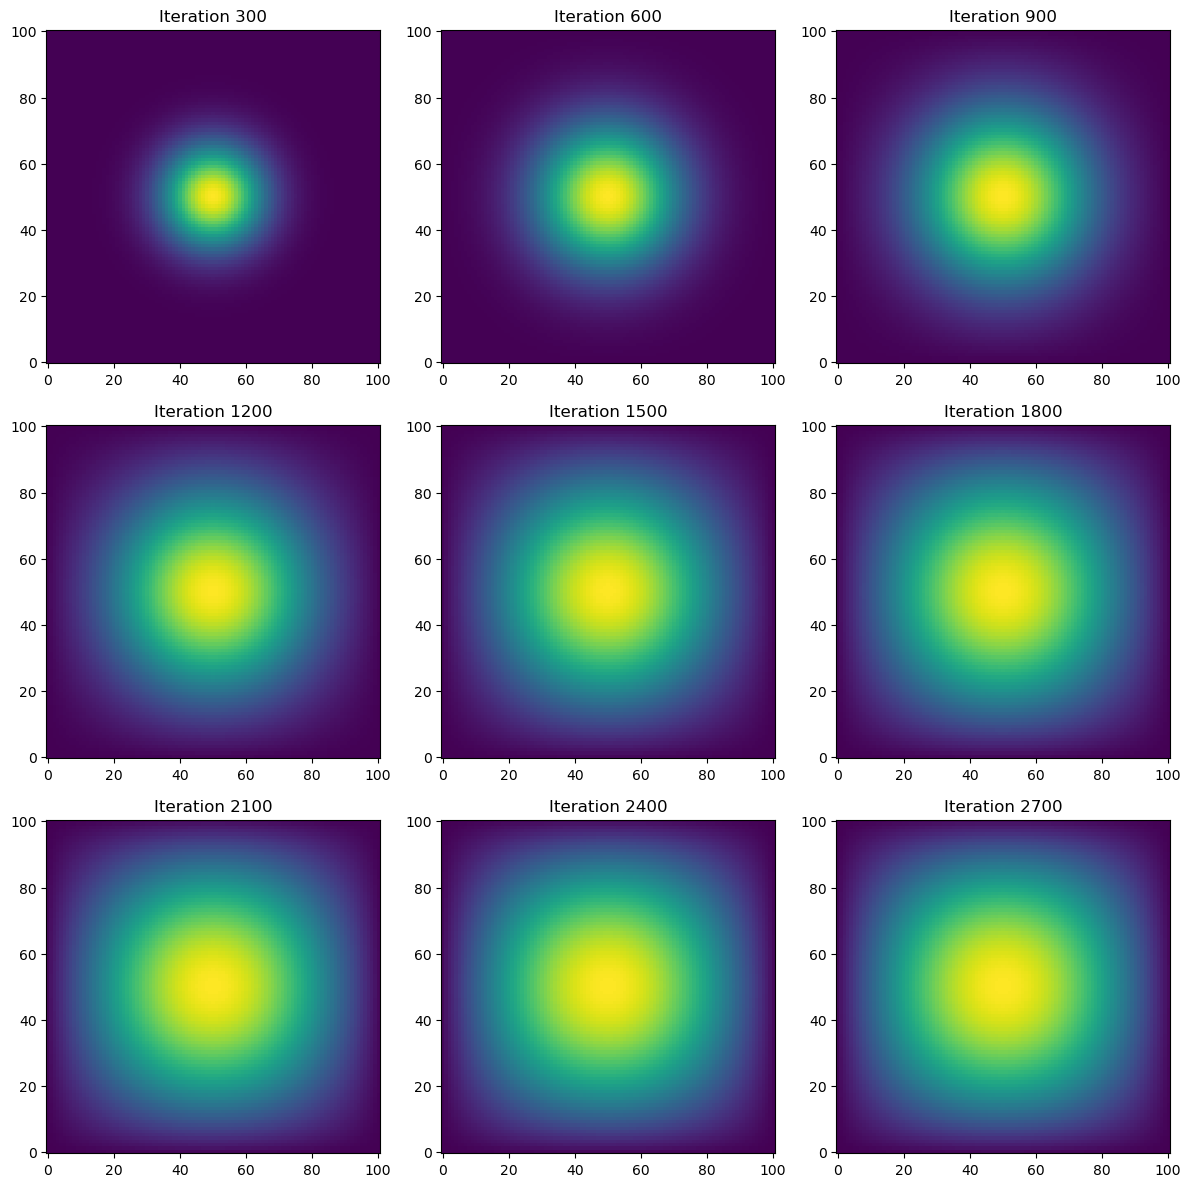

In [14]:
heat_simulation(N, epsilon, iterations, "matrix multiplication", matrix=get_A, advance=advance_time_matvecmul)

## Method 2: Sparse Matrix in JAX
In this method, we will be using sparse matrix operations to optimize performance. The matrix A is sparse because most of its elements are zero, representing the fact that each grid point only interacts with its immediate neighbors. Instead of storing the entire matrix, we use a Batched Coordinate (BCOO) sparse format, which stores only the nonzero values. This reduces both the space and computational complexity to O(N^2), making it faster.

Here’s the implementation of **get_sparse_A(N)** to return A in sparse format:

In [8]:
def get_sparse_A(N):
    """
    Returns the finite difference matrix A in a sparse format compatible 
    with JAX.
    
    Args:
        N (int): The size of the grid (NxN).
        
    Returns:
        A_sp_matrix: The sparse finite difference matrix A in BCOO format,  
                     which is efficient for sparse matrix operations in JAX.
    """
    dense_matrix = jnp.array(get_A(N))

    # Convert to sparse BCOO format
    A_sp_matrix = sparse.BCOO.fromdense(dense_matrix)
    
    return A_sp_matrix

Now that we have our matrix A defined, we can run the simulation by calling the **get_sparse_A(N)** function alongside the jit-ed version of **advance_time_matvecmul()** method. This will simulate the heat diffusion process for 2700 iterations, with each iteration representing a time step in the diffusion process.

In [9]:
print(inspect.getsource(heat_simulation))

def heat_simulation(N, epsilon, iterations, method, matrix, advance):
    # Define parameters
    iterations = iterations
    
    # Initialize heat source at center
    # Checks for what model
    if advance == advance_time_jax:
        u = jnp.zeros((N, N))
        u = u.at[N//2, N//2].set(1.0)
    else:
        u = np.zeros((N, N))
        u[N//2, N//2] = 1.0 
    
    # Get matrix A
    A = matrix(N)
    
    # Run a few warm-up iterations to compile (only need for JAX)
    if advance == advance_time_jax:
        for _ in range(5):
            u = advance_time_jax(u, epsilon)
    
    # Store for visualization
    graph = []
    
    # Track computation time
    start_time = time.time()
    
    # Run
    for i in range(iterations):
        # Checks for which model
        if advance == advance_time_matvecmul:
            u = advance(A, u, epsilon)
        else:
            u = advance(u, epsilon)
        
        # Save every 300 steps
        if (i+1) % 300 == 0:  
            gr

Total computation time (sparse matrix in JAX): 1.29 seconds


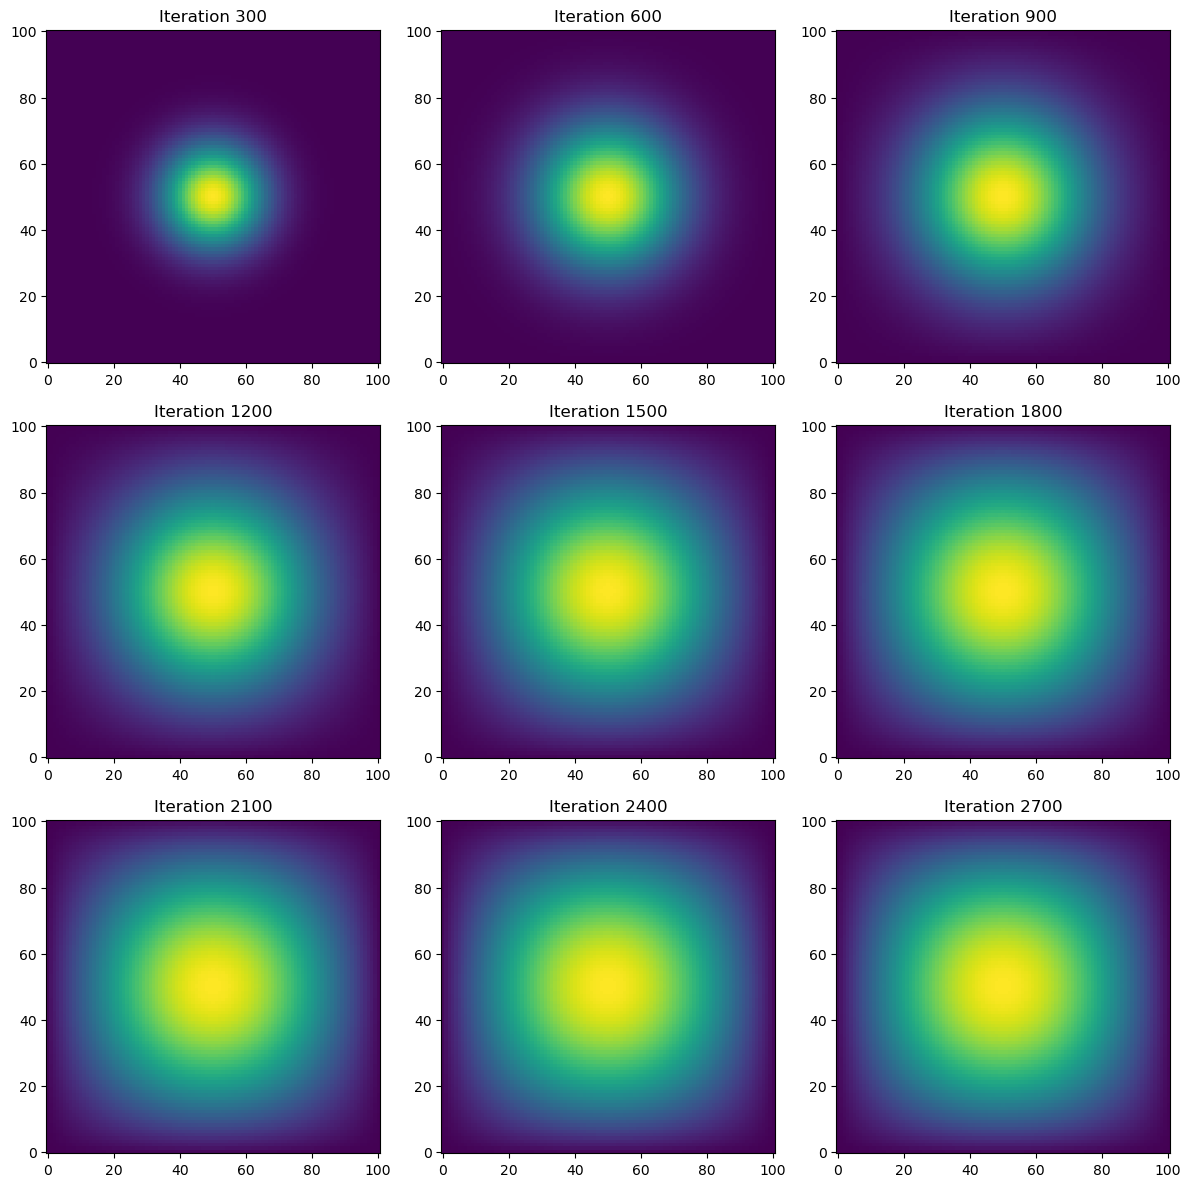

In [10]:
heat_simulation(N, epsilon, iterations, "sparse matrix in JAX", matrix=get_sparse_A, advance=advance_time_matvecmul)

## Method 3: Direct Operation with NumPy

We can simplify the solution by using vectorized array operations, which makes it more efficient to shifting grid elements and simulate heat diffusion.

Here's how you can implement the **advance_time_numpy()** function in **heat_equation.py** to advance the solution by one timestep:

This function advances the state of the grid by one timestep, simulating how heat diffuses across a 2D grid of size N×N, where each grid point represents a temperature. The function uses the *finite difference method* to approximate the heat equation, specifically its Laplacian operator, which describes how the temperature changes based on neighboring points.

In [11]:
def advance_time_numpy(u, epsilon):
    """
    Advances the simulation of heat diffusion by one timestep using 
    explicit indexing and zero-padding.
    
    Args:
        u (numpy.ndarray): N x N grid state at timestep k.
        epsilon (float): Stability constant.
    
    Returns:
        numpy.ndarray: N x N Grid state at timestep k+1.
    """
    # Pad the input array with zeros (1 layer around the grid)
    padded = np.pad(u, pad_width=1, mode='constant', constant_values=0)

    # Compute the Laplacian
    laplacian = (
        # Shift down
        padded[2:, 1:-1] +  
        # Shift up
        padded[0:-2, 1:-1] +  
        # Shift right
        padded[1:-1, 2:] +  
        # Shift left
        padded[1:-1, 0:-2] -
        # Center
        4 * u  
    )

    # Update
    u_new = u + epsilon * laplacian

    return u_new

The **advance_time_numpy()** function simulates heat diffusion in a grid. It first pads the input grid with zeros to handle boundary conditions, then computes the Laplacian by explicitly indexing the padded grid to access neighboring points (up, down, left, right). 

This updated grid is returned as the new state at the next timestep. The method is efficient and uses NumPy's slicing and padding capabilities to avoid boundary issues.

Now that we have our **advance_time_numpy()** function, we can run the simulation for 2700 iterations, just like before. We will also store snapshots of the grid every 300 iterations to visualize how the heat diffuses over time.

Here’s how you can implement the simulation:

In [13]:
print(inspect.getsource(heat_simulation))

def heat_simulation(N, epsilon, iterations, method, matrix, advance):
    # Define parameters
    iterations = iterations
    
    # Initialize heat source at center
    # Checks for what model
    if advance == advance_time_jax:
        u = jnp.zeros((N, N))
        u = u.at[N//2, N//2].set(1.0)
    else:
        u = np.zeros((N, N))
        u[N//2, N//2] = 1.0 
    
    # Get matrix A
    A = matrix(N)
    
    # Run a few warm-up iterations to compile (only need for JAX)
    if advance == advance_time_jax:
        for _ in range(5):
            u = advance_time_jax(u, epsilon)
    
    # Store for visualization
    graph = []
    
    # Track computation time
    start_time = time.time()
    
    # Run
    for i in range(iterations):
        # Checks for which model
        if advance == advance_time_matvecmul:
            u = advance(A, u, epsilon)
        else:
            u = advance(u, epsilon)
        
        # Save every 300 steps
        if (i+1) % 300 == 0:  
            gr

Total computation time (NumPy): 0.21 seconds


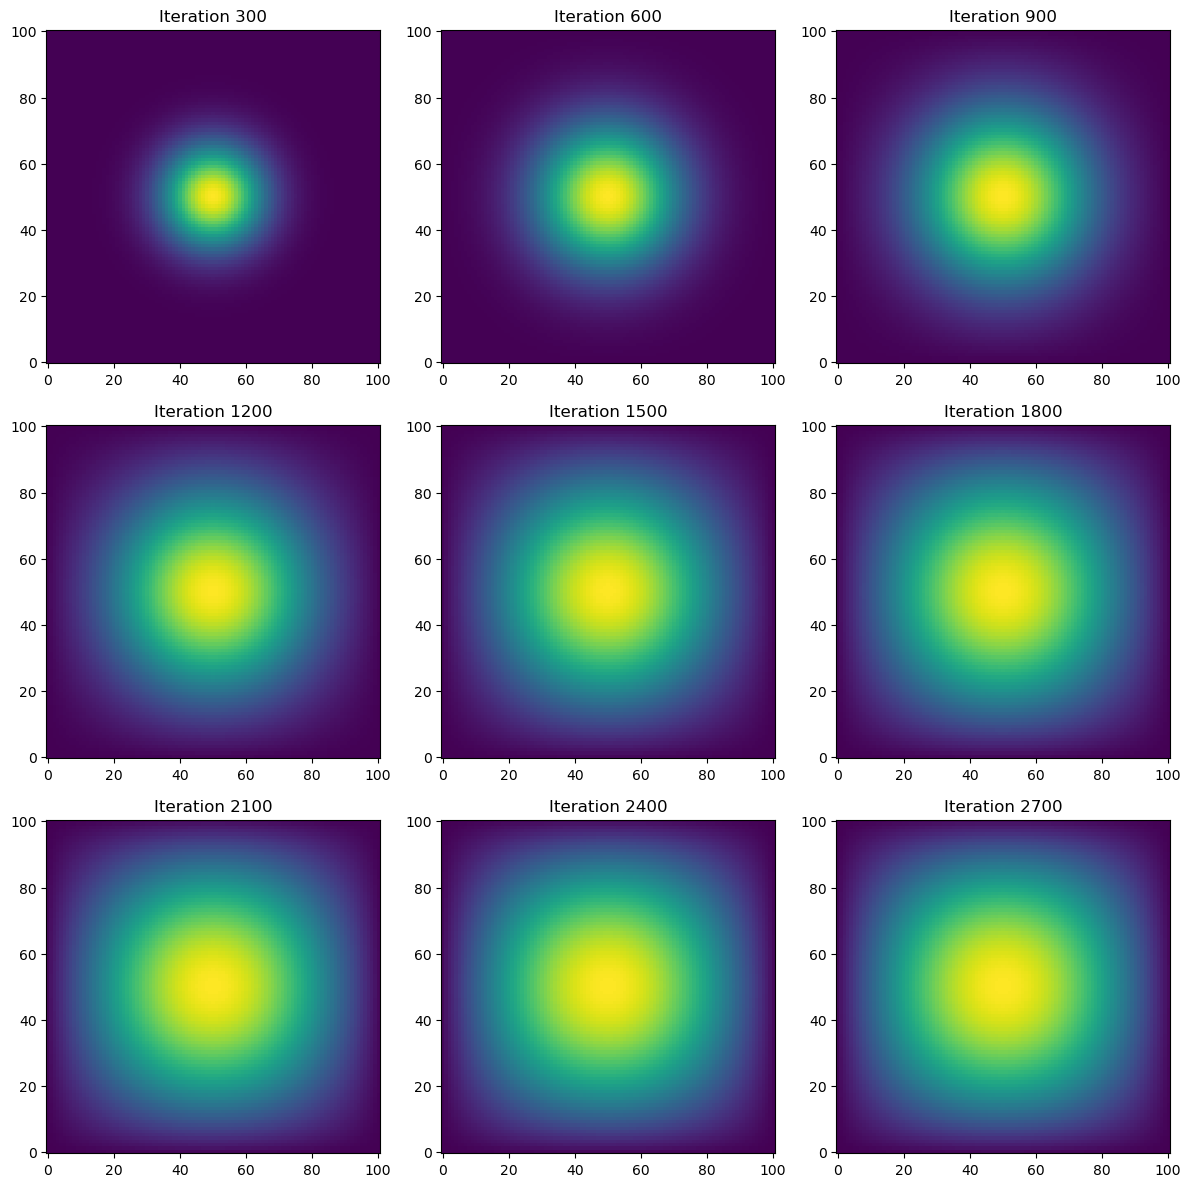

In [14]:
heat_simulation(N, epsilon, iterations, "NumPy", matrix=get_A, advance=advance_time_numpy)

## Method 4: With Jax

In this method of the heat diffusion simulation, we take advantage of JAX's Just-In-Time (JIT) compilation to speed up the computation. By using jax.numpy and the @jit decorator, we optimize the **advance_time_jax()** function for efficient execution. 

The function simulates heat diffusion by updating the grid state using explicit slicing, similar to the advance_time_numpy() function, but with JAX's array operations. Here is a way to implement it:

In [10]:
@jit
def advance_time_jax(u, epsilon):
    """
    Advances the heat equation using jax.numpy with explicit slicing.
    
    Args:
        u (jax.numpy.ndarray): N x N grid state at timestep k.
        epsilon (float): Stability constant.
    
    Returns:
        jax.numpy.ndarray: N x N Grid state at timestep k+1.
    """
    # Pad the input array with zeros
    padded = jnp.pad(u, pad_width=1, mode='constant', constant_values=0)

    # Compute the Laplacian using slicing
    laplacian = (
        padded[2:, 1:-1] +  # Shift down
        padded[0:-2, 1:-1] +  # Shift up
        padded[1:-1, 2:] +  # Shift right
        padded[1:-1, 0:-2] -  # Shift left
        4 * u  # Center
    )

    # Update with forward Euler step
    u_new = u + epsilon * laplacian

    return u_new

Now that we have our **advance_time_jax()** function, we can run the simulation for 2700 iterations, just like before. We will also store snapshots of the grid every 300 iterations to visualize how the heat diffuses over time.

Here’s how you can implement the simulation:

In [15]:
print(inspect.getsource(heat_simulation))

def heat_simulation(N, epsilon, iterations, method, matrix, advance):
    # Define parameters
    iterations = iterations
    
    # Initialize heat source at center
    # Checks for what model
    if advance == advance_time_jax:
        u = jnp.zeros((N, N))
        u = u.at[N//2, N//2].set(1.0)
    else:
        u = np.zeros((N, N))
        u[N//2, N//2] = 1.0 
    
    # Get matrix A
    A = matrix(N)
    
    # Run a few warm-up iterations to compile (only need for JAX)
    if advance == advance_time_jax:
        for _ in range(5):
            u = advance_time_jax(u, epsilon)
    
    # Store for visualization
    graph = []
    
    # Track computation time
    start_time = time.time()
    
    # Run
    for i in range(iterations):
        # Checks for which model
        if advance == advance_time_matvecmul:
            u = advance(A, u, epsilon)
        else:
            u = advance(u, epsilon)
        
        # Save every 300 steps
        if (i+1) % 300 == 0:  
            gr

Total computation time (JAX): 0.10 seconds


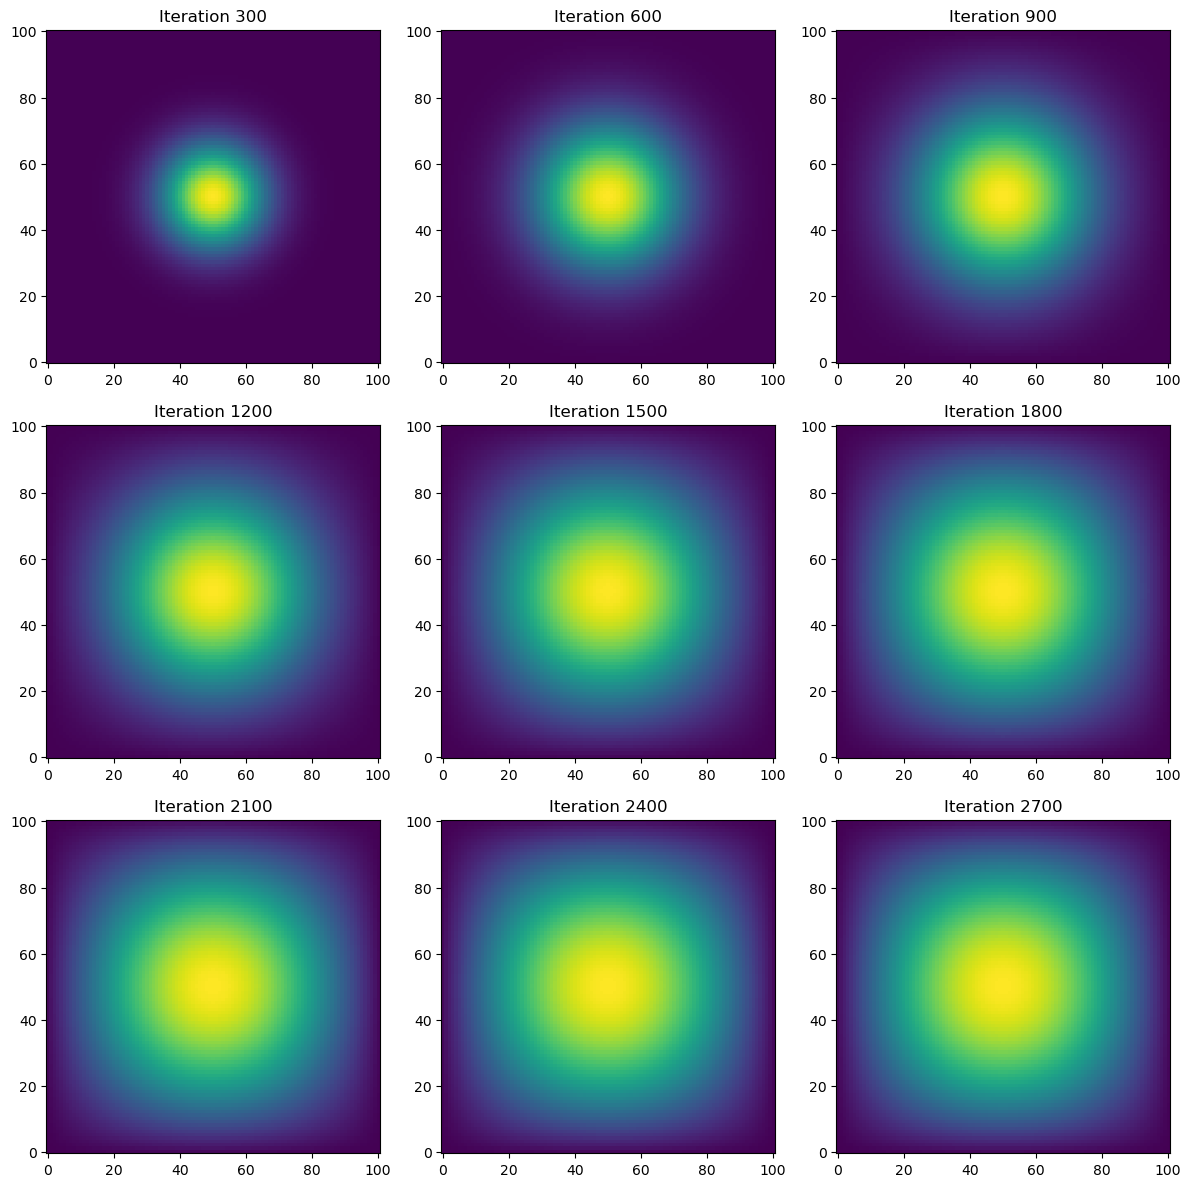

In [16]:
heat_simulation(N, epsilon, iterations, "JAX", matrix=get_A, advance=advance_time_jax)

To make sure that the code runs optimally, we first run a few warm-up iterations, allowing JAX to compile the function. Then, we run the full simulation for 2700 iterations. The performance boost comes from JAX's ability to compile the function ahead of time and execute it much faster than pure Python or NumPy-based implementations. By visualizing the heat diffusion every 300 iterations, we can track the progress of the simulation, ensuring everything works as expected.

The JAX approach is not only more efficient in terms of performance but also avoids the need for explicit matrix multiplication, making the code simpler while still achieving high-performance results.

## Comparison
**1. Matrix-Vector Multiplication:**
- *Performance:* Slow due to inefficiency - 424.18 seconds
- *Ease:* Hard to understand mathematically and complex to implement.

**2. Sparse Matrix Representation:**
- *Performance:* Faster than dense matrices by focusing on non-zero elements - 1.29 seconds
- *Ease:* Easier to implement due to sparse matrices.

**3. NumPy-based Computation:**
- *Performance:* Fast and efficient - 0.21 seconds
- *Ease:* Easy to implement using simple array slicing and comfort with NumPy.

**4. JAX-based Computation with JIT:**
- *Performance:* The fastest due to JIT compilation - 0.10 seconds
- *Ease:* Similar to NumPy.

**Conclusion:**
- *Fastest:* JAX with JIT.
- *Easiest to Write:* NumPy-based because I am most comfortable with NumPy.